At some point online I saw someone calculate Neil Armstrong's mean lifetime altitude. This seems like a complete Randall Monroe of xkcd.com kind of thing. But I cannot for the life of me find the link now to put it here.

Update 2022-11-10: [I found it](https://twitter.com/whatifnumbers/status/1200105688938295298)
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">71.4: Neil Armstrong’s lifetime average height above the Earth’s surface in kilometers</p>&mdash; What-If Numbers (@whatifnumbers) <a href="https://twitter.com/whatifnumbers/status/1200105688938295298?ref_src=twsrc%5Etfw">November 28, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Anyway I needed a silly toy problem to test the Jupyter notebook to blog post capability of some software I'm using it. So here I am... extending the Armstrong problem to the case of a still-alive astronaut who's lifetime mean altitude is slowly decreasing.

I mean, we all want him to live as long as possible, but he's ruining his lifetime altitude with his longevity ;)

Buzz graduated USMA in 1951. By 1972 at retirement he already had 3500 hours flying time [[1](https://www.nationalaviation.org/our-enshrinees/aldrin-buzz/)]

So to model Buzz's aviation career, I'll assume 9km average flight altitude (~30kft), and spread flight hours evenly over 1951-1972.

To model Gemini 12, I use the data from [[2](https://en.wikipedia.org/wiki/Gemini_12)]
and assume mean orbital distance of apogee and perigee for the duration of the flight.

To model Apollo 11, I used data from the following sources to get information on the flight profile [[3](https://airandspace.si.edu/sites/default/files/images/5317h.jpg),
[4](https://history.nasa.gov/SP-4029.pdf), and Table 7.11 of [5](https://www.hq.nasa.gov/alsj/a11/a11MIssionReport_1971)]. While the change in altitude per unit time during a flight phase is not constant (Earth's gravity, yo), a quick check I did with a linear interpolation (visible in the code) led me to believe that the difference between real orbital mechanics model and just taking the average altitude of a flight phase would only be a matter of a few percent and not really worth caring about in this context. 


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# convert nautical miles to kilometers
NMi2Km = 1.852

# per wiki he graduated USMA in 1951 and by 1972 at retirement. I made up the graduation date
# he already had 3500 hours flying time per https://www.nationalaviation.org/our-enshrinees/aldrin-buzz/
# assume 9km average flight altitude (~30kft)
AFstart = pd.Timestamp('May 1, 1951 12:00:00 UTC')
AFend = pd.Timestamp('July 1, 1971 12:00:00 UTC')
AFdur = AFend - AFstart 
AFeffectiveAlt = 9 * pd.Timedelta('3500 hours') / AFdur # spread flight hours over the whole AF career evenly

# Gemini 12 https://en.wikipedia.org/wiki/Gemini_12
# assume mean orbital distance of apogee and perigee
G12start = pd.Timestamp('November 11, 1966, 20:46:33 UTC')
G12end = pd.Timestamp('November 15, 1966, 19:21:04 UTC')
G12meanAlt = np.mean([160,270]) # already in km from wiki

# Apollo 11 https://airandspace.si.edu/sites/default/files/images/5317h.jpg
# https://history.nasa.gov/SP-4029.pdf
# Table 7.11 of https://www.hq.nasa.gov/alsj/a11/a11MIssionReport_1971015566.pdf
MoonMeanDistKm = 384400
A11liftoff = pd.Timestamp('July 16, 1969, 13:32:00 UTC') 
A11EarthOrbitAlt = 100 * NMi2Km # this is rough
A11TLI = A11liftoff + pd.Timedelta('2 hours 50 minutes')
A11MidcourseOut = A11liftoff + pd.Timedelta('26 hours 45 minutes')
A11MidcourseAlt = 109475 * NMi2Km
A11LunarInsert = A11liftoff + pd.Timedelta('75 hours 50 minutes')
A11TEI = A11liftoff + pd.Timedelta('135 hours 24 minutes')
A11splashdown = A11liftoff + pd.Timedelta('195 hours 18 minutes')
# lets check to see if we need to do any detailed interpolation, or if mean is enough...
# print(109475 * NMi2Km / MoonMeanDistKm, (A11MidcourseOut - A11TLI) / (A11LunarInsert - A11MidcourseOut))
# > 0.5274393860561915 0.4872665534804754
# this is close enough to linear interpolation that I'm not going to bother with anything else
# so for the duration of the flight from earth to moon, just fill in 1/2 the lunar distance

baidx = pd.date_range(start='January 20, 1930',end='November 10, 2022',freq='H',tz='UTC')
BuzzAlt = pd.Series(0,index=baidx)
BuzzAlt.loc[AFstart:AFend] = AFeffectiveAlt
BuzzAlt.loc[G12start:G12end] = G12meanAlt
BuzzAlt.loc[A11liftoff:A11TLI] = A11EarthOrbitAlt
BuzzAlt.loc[A11TLI:A11LunarInsert] = MoonMeanDistKm / 2
BuzzAlt.loc[A11LunarInsert:A11TEI] = MoonMeanDistKm
BuzzAlt.loc[A11TEI:A11splashdown] = MoonMeanDistKm / 2

#BuzzAlt.plot(logy=True, ylim=(1,1000000));
#plt.ylabel('kilometers');
#plt.xlabel('on this date');
#plt.title('Aldrin\'s altitude history - log scale');
#plt.annotate('Gemini 12', xy=(G12start,2*10**2), xycoords='data', xytext=(-55,0), textcoords='offset points');
#plt.annotate('Apollo 11', xy=(A11liftoff,4*10**5), xycoords='data', xytext=(5,0), textcoords='offset points');

print('\tWhen this post was first published in Feb 2020,\nAldrin\'s lifetime mean altitude was {:3.1f} km'.format(BuzzAlt[:'2020-02-02'].mean()))
print('\n\tNow (Nov 2022) Aldrin\'s lifetime mean altitude\nis {:3.1f} km and dropping \U0001F680\U0001F913'.format(BuzzAlt.mean()))

	When this post was first published in Feb 2020,
Aldrin's lifetime mean altitude was 61.2 km

	Now (Nov 2022) Aldrin's lifetime mean altitude
is 59.4 km and dropping 🚀🤓


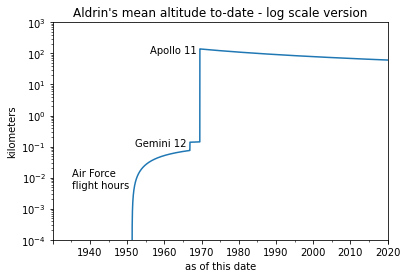

In [10]:
BuzzAlt.expanding().mean().plot(logy=True,ylim=(0.0001,1000));
plt.ylabel('kilometers');
plt.xlabel('as of this date');
plt.title('Aldrin\'s mean altitude to-date - log scale version');
plt.annotate('Gemini 12', xy=(G12start,10**-1), xycoords='data', xytext=(-55,0), textcoords='offset points');
plt.annotate('Apollo 11', xy=(A11liftoff,10**2), xycoords='data', xytext=(-50,0), textcoords='offset points');
plt.annotate('Air Force\nflight hours', xy=(AFstart,10**-2), xycoords='data', xytext=(-60,-10), textcoords='offset points');

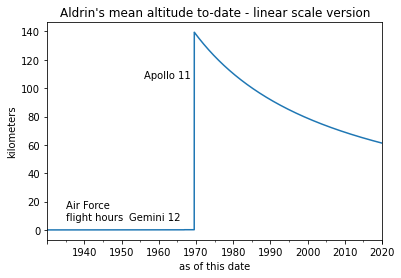

In [9]:
# same thing, but linear y-axis instead of log
BuzzAlt.expanding().mean().plot();
plt.ylabel('kilometers');
plt.xlabel('as of this date');
plt.title('Aldrin\'s mean altitude to-date - linear scale version');
plt.annotate('Gemini 12', xy=(G12start,10**-1), xycoords='data', xytext=(-55,10), textcoords='offset points');
plt.annotate('Apollo 11', xy=(A11liftoff,10**2), xycoords='data', xytext=(-50,10), textcoords='offset points');
plt.annotate('Air Force\nflight hours', xy=(AFstart,10**-2), xycoords='data', xytext=(-60,10), textcoords='offset points');